In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
######## 读取数据 ########
sheet = pd.read_excel('data_input/美国10债Trend2.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

In [4]:
sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8514 entries, 0 to 8513
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        8514 non-null   datetime64[ns]
 1   10年期美国国债收益率                 8514 non-null   float64       
 2   10年期美国国债收益率Trend/F0.05      8513 non-null   float64       
 3   10年期美国国债收益率Non-Trend/F0.05  8513 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 266.2 KB


In [5]:
sheet.tail()

,Date,10年期美国国债收益率,10年期美国国债收益率Trend/F0.05,10年期美国国债收益率Non-Trend/F0.05
8509,2025-11-03,4.13,4.248025,-0.1180
8510,2025-11-04,4.10,4.247479,-0.1475
8511,2025-11-05,4.17,4.246928,-0.0769
8512,2025-11-06,4.11,4.246374,-0.1364
8513,2025-11-07,4.11,NaN,NaN


In [6]:
sheet =  sheet[['Date','10年期美国国债收益率Trend/F0.05','10年期美国国债收益率']]
# 对两列进行线性插值填充空缺值
sheet['10年期美国国债收益率Trend/F0.05'] = sheet['10年期美国国债收益率Trend/F0.05'].interpolate(method='linear')
sheet['10年期美国国债收益率'] = sheet['10年期美国国债收益率'].interpolate(method='linear')

sheet = sheet.dropna()

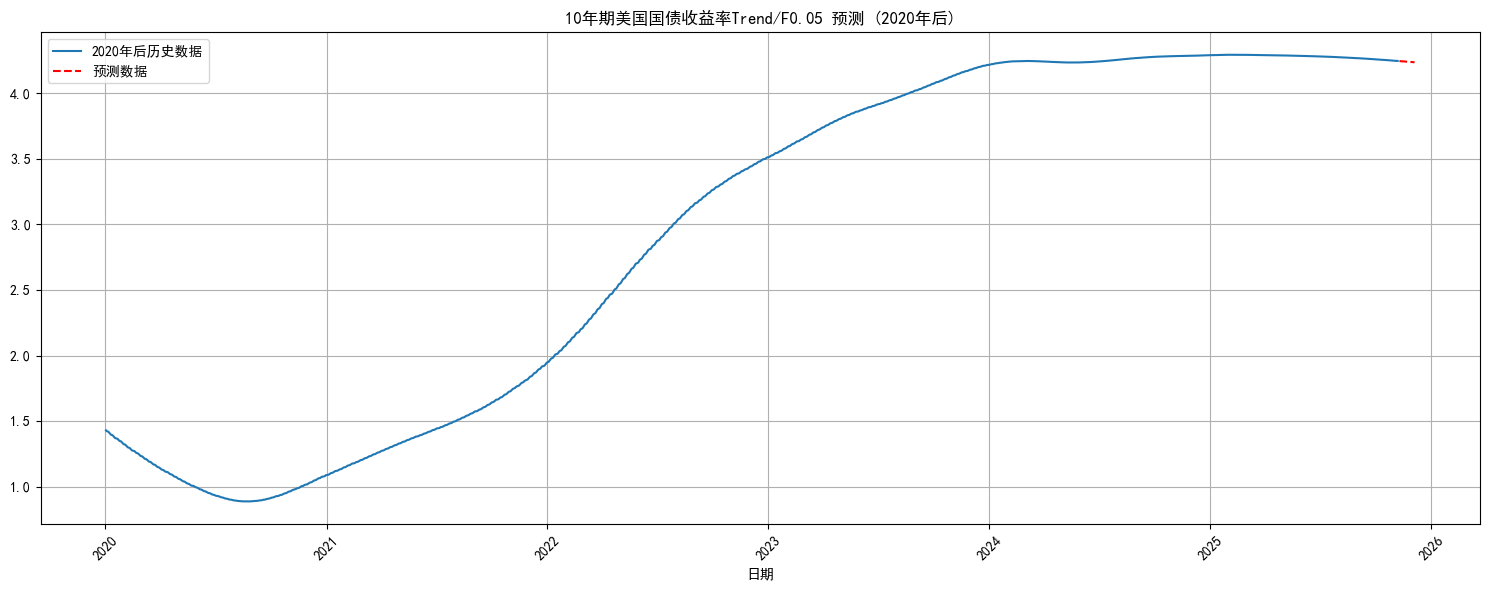

In [7]:

# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])

# 生成未来20个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')  # 生成30天以确保获得20个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:20]  # 只保留工作日并取前20天

# 获取最后30个历史值用于线性回归
last_values = sheet['10年期美国国债收益率Trend/F0.05'].tail(30).values
x = np.arange(len(last_values))
y = last_values

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 预测未来20个值
future_x = np.arange(len(last_values), len(last_values) + 20)
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '10年期美国国债收益率Trend/F0.05': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['10年期美国国债收益率Trend/F0.05'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['10年期美国国债收益率Trend/F0.05'], 'r--', label='预测数据')
plt.title('10年期美国国债收益率Trend/F0.05 预测 (2020年后)')
plt.xlabel('日期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/10年期美国国债收益率Non-Trend-F0.05_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])
# trend + non-trend 
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '10年期美国国债收益率Trend/F0.05']], 
    on='Date',
    how='outer'
)


In [9]:
sheet_non_trend

,Date,真实值,预测值
0,2025-12-05,NaN,-0.1340
1,2025-12-04,NaN,-0.1228
2,2025-12-03,NaN,-0.1251
3,2025-12-02,NaN,-0.1367
4,2025-12-01,NaN,-0.1564
...,...,...,...
750,2023-01-09,0.0013,NaN
751,2023-01-06,0.0249,NaN
752,2023-01-05,0.1885,NaN
753,2023-01-04,0.1722,NaN


In [10]:
merged_df = merged_df
merged_df

,Date,预测值,10年期美国国债收益率Trend/F0.05
0,2023-01-03,NaN,NaN
1,2023-01-04,NaN,NaN
2,2023-01-05,NaN,NaN
3,2023-01-06,NaN,NaN
4,2023-01-09,NaN,NaN
...,...,...,...
750,2025-12-01,-0.1564,4.238144
751,2025-12-02,-0.1367,4.237643
752,2025-12-03,-0.1251,4.237143
753,2025-12-04,-0.1228,4.236643


In [11]:
# 删除包含空值的行

# 计算最终的
merged_df['10年期美国国债收益率'] = merged_df['预测值'] + merged_df['10年期美国国债收益率Trend/F0.05']
merged_df.tail()

,Date,预测值,10年期美国国债收益率Trend/F0.05,10年期美国国债收益率
750,2025-12-01,-0.1564,4.238144,4.081744
751,2025-12-02,-0.1367,4.237643,4.100943
752,2025-12-03,-0.1251,4.237143,4.112043
753,2025-12-04,-0.1228,4.236643,4.113843
754,2025-12-05,-0.1340,4.236142,4.102142


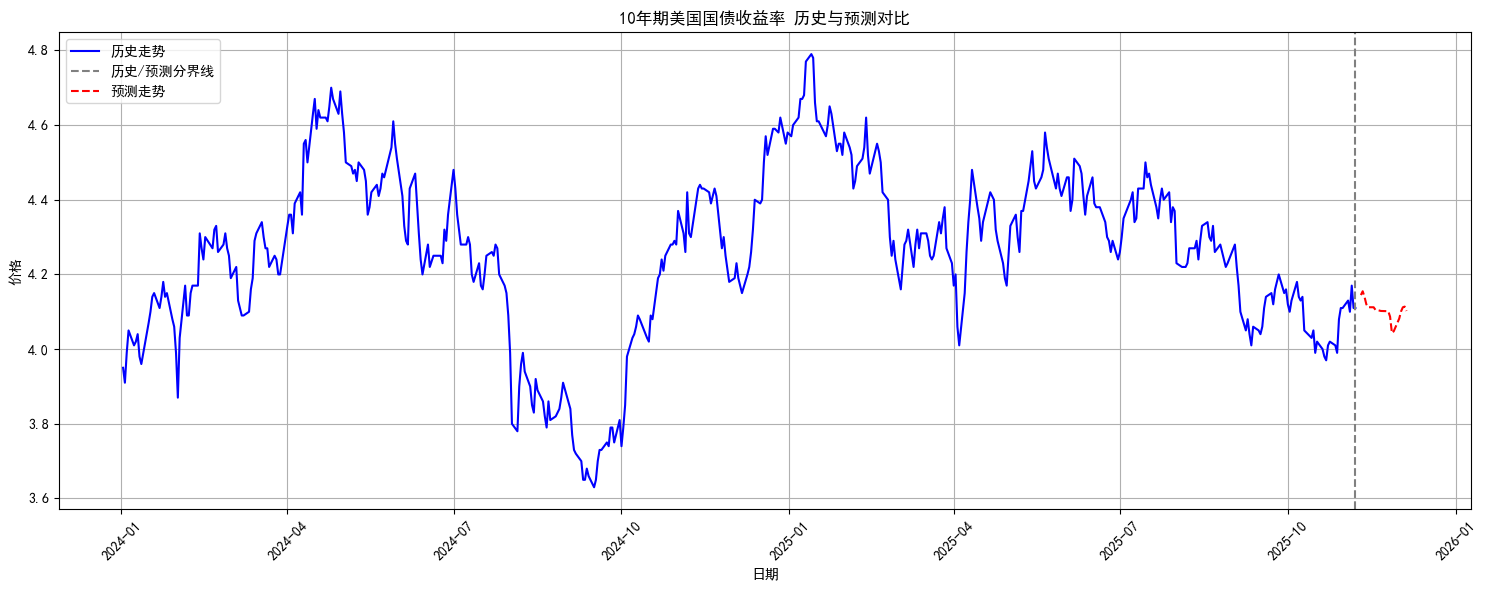

In [12]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']
# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['10年期美国国债收益率'], label='历史走势', color='blue')
# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')
# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['10年期美国国债收益率'], label='预测走势', color='red', linestyle='--')

plt.title('10年期美国国债收益率 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '10年期美国国债收益率']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '10年期美国国债收益率']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/10年期美国国债收益率_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi

,Date,实际值,10年期美国国债收益率
754,2025/12/05,NaN,4.102142
753,2025/12/04,NaN,4.113843
752,2025/12/03,NaN,4.112043
751,2025/12/02,NaN,4.100943
750,2025/12/01,NaN,4.081744
...,...,...,...
4,2023/01/09,3.53,NaN
3,2023/01/06,3.55,NaN
2,2023/01/05,3.71,NaN
1,2023/01/04,3.69,NaN


In [14]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
monthly_df_shizhi = monthly_df_shizhi.dropna(subset=['实际值', '10年期美国国债收益率'], how='all')
# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/10年期美国国债收益率_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,10年期美国国债收益率
0,2025/12/31,NaN,4.102142
1,2025/11/30,4.11,4.047744
2,2025/10/31,4.11,NaN
3,2025/09/30,4.16,NaN
4,2025/08/31,4.23,NaN


---

In [15]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '10年期美国国债收益率Trend/F0.05']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/10年期美国国债收益率Trend—F0.05_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_trend

,Date,实际值,10年期美国国债收益率Trend/F0.05
733,2025/12/05,NaN,4.236142
732,2025/12/04,NaN,4.236643
731,2025/12/03,NaN,4.237143
730,2025/12/02,NaN,4.237643
729,2025/12/01,NaN,4.238144
...,...,...,...
4,2023/01/09,3.528749,NaN
3,2023/01/06,3.525106,NaN
2,2023/01/05,3.521462,NaN
1,2023/01/04,3.517818,NaN


In [16]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/10年期美国国债收益率Trend—F0.05_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_trend.head()

,Date,实际值,10年期美国国债收益率Trend/F0.05
0,2025/12/31,NaN,4.236142
1,2025/11/30,4.246374,4.238644
2,2025/10/31,4.248568,NaN
3,2025/09/30,4.259527,NaN
4,2025/08/31,4.268197,NaN


---

In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率Trend/F0.05_2.0"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率_2.0"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [19]:
from Lcel import update_excel_data
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率Trend/F0.05_2.0"
# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [20]:
from Lcel import update_excel_data
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率_2.0"
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
